In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [4]:
df = pd.read_csv("preprocessed_EDA_data.csv")

In [7]:
df.head()

,State,Crop,Year,Season,Yield,Annual_Rainfall,Fertilizer,Pesticide
0,andhra pradesh,arecanut,2001,whole year,1.673152,928.4,102.13,0.26
1,andhra pradesh,arecanut,2002,whole year,1.441065,648.1,94.67,0.25
2,andhra pradesh,arecanut,2003,whole year,0.710526,826.0,98.98,0.24
3,andhra pradesh,arecanut,2001,whole year,1.714286,928.4,102.13,0.26
4,andhra pradesh,arecanut,2002,whole year,1.428571,648.1,94.67,0.25


In [9]:
df.columns.tolist()

['State',
 'Crop',
 'Year',
 'Season',
 'Yield',
 'Annual_Rainfall',
 'Fertilizer',
 'Pesticide']

In [11]:
df.shape

(266733, 8)

HERE WE ARE ENCODING DIFFERENT COLUMN ATTRIBUTES

In [14]:
df_encoded = df.copy()
label_mappings = {}

for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

print("Label encoding done.")
print("Label mappings:", label_mappings)

Label encoding done.
Label mappings: {'State': {'andhra pradesh': 0, 'arunachal pradesh': 1, 'assam': 2, 'bihar': 3, 'chhattisgarh': 4, 'delhi': 5, 'goa': 6, 'gujarat': 7, 'haryana': 8, 'himachal pradesh': 9, 'jammu and kashmir': 10, 'jharkhand': 11, 'karnataka': 12, 'kerala': 13, 'madhya pradesh': 14, 'maharashtra': 15, 'manipur': 16, 'meghalaya': 17, 'mizoram': 18, 'nagaland': 19, 'odisha': 20, 'puducherry': 21, 'punjab': 22, 'sikkim': 23, 'tamil nadu': 24, 'telangana': 25, 'tripura': 26, 'uttar pradesh': 27, 'uttarakhand': 28, 'west bengal': 29}, 'Crop': {'arecanut': 0, 'arhar/tur': 1, 'bajra': 2, 'banana': 3, 'barley': 4, 'black pepper': 5, 'cardamom': 6, 'cashewnut': 7, 'castor seed': 8, 'coconut': 9, 'coriander': 10, 'cotton(lint)': 11, 'cowpea(lobia)': 12, 'dry chillies': 13, 'garlic': 14, 'ginger': 15, 'gram': 16, 'groundnut': 17, 'guar seed': 18, 'horse-gram': 19, 'jowar': 20, 'jute': 21, 'khesari': 22, 'linseed': 23, 'maize': 24, 'masoor': 25, 'mesta': 26, 'moong(green gram)'

In [16]:
X = df_encoded.drop('Yield', axis=1)
y = df_encoded['Yield']


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

xgb = XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

lgb = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 213386, number of used features: 7
[LightGBM] [Info] Start training from score 92.734397


In [21]:
models = ['Random Forest', 'XGBoost', 'LightGBM']
predictions = [rf_pred, xgb_pred, lgb_pred]

print("\n📈 Model Performance Comparison (Before Tuning):")
for m, pred in zip(models, predictions):
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{m}: R²={r2:.3f}, MAE={mae:.3f}, RMSE={rmse:.3f}")


📈 Model Performance Comparison (Before Tuning):
Random Forest: R²=0.880, MAE=22.068, RMSE=333.599
XGBoost: R²=0.880, MAE=22.608, RMSE=333.942
LightGBM: R²=0.880, MAE=22.764, RMSE=333.333


In [26]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


In [30]:
import optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 30),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42
    }

    model = LGBMRegressor(**params)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='r2', n_jobs=-1)
    return scores.mean()

print("\n🚀 Running Optuna Hyperparameter Tuning for LightGBM...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("\n✅ Best parameters found:")
print(study.best_params)

[I 2025-11-05 15:58:02,501] A new study created in memory with name: no-name-e4d64fae-5b40-487e-aef8-efcb92d20d55



🚀 Running Optuna Hyperparameter Tuning for LightGBM...


[I 2025-11-05 15:58:09,709] Trial 0 finished with value: 0.8718309041255708 and parameters: {'n_estimators': 551, 'learning_rate': 0.04104239810206409, 'num_leaves': 115, 'max_depth': 6, 'min_child_samples': 69, 'subsample': 0.9126720474924326, 'colsample_bytree': 0.8170648305798758, 'reg_alpha': 0.4479266023581423, 'reg_lambda': 0.552093007837455}. Best is trial 0 with value: 0.8718309041255708.
[I 2025-11-05 15:58:16,877] Trial 1 finished with value: 0.8686300397664959 and parameters: {'n_estimators': 646, 'learning_rate': 0.08227839624470903, 'num_leaves': 59, 'max_depth': 22, 'min_child_samples': 14, 'subsample': 0.9154813378536377, 'colsample_bytree': 0.730016366124558, 'reg_alpha': 0.38179624006105906, 'reg_lambda': 0.14552832534081173}. Best is trial 0 with value: 0.8718309041255708.
[I 2025-11-05 15:58:23,519] Trial 2 finished with value: 0.8690048093635377 and parameters: {'n_estimators': 435, 'learning_rate': 0.1038232846595732, 'num_leaves': 74, 'max_depth': 19, 'min_child_s


✅ Best parameters found:
{'n_estimators': 796, 'learning_rate': 0.010022517808435615, 'num_leaves': 150, 'max_depth': 30, 'min_child_samples': 91, 'subsample': 0.796176058723052, 'colsample_bytree': 0.8419430133234674, 'reg_alpha': 0.6610920354070046, 'reg_lambda': 0.9641571779293812}


In [32]:
best_params = study.best_params
best_lgb = LGBMRegressor(**best_params)
best_lgb.fit(X_train, y_train)

y_pred_best = best_lgb.predict(X_test)

r2_best = r2_score(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print("\n🔥 Tuned LightGBM Results:")
print(f"R²={r2_best:.3f}, MAE={mae_best:.3f}, RMSE={rmse_best:.3f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 659
[LightGBM] [Info] Number of data points in the train set: 213386, number of used features: 7
[LightGBM] [Info] Start training from score 92.734397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [34]:
lgb_pred = y_pred_best

In [36]:
print("\n📊 Final Model Performance Comparison:")
print("-" * 45)

models = ['Random Forest', 'XGBoost', 'LightGBM (Tuned)']
preds = [rf_pred, xgb_pred, lgb_pred]

for m, pred in zip(models, preds):
    r2 = r2_score(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    print(f"{m}: R²={r2:.3f}, MAE={mae:.3f}, RMSE={rmse:.3f}")


📊 Final Model Performance Comparison:
---------------------------------------------
Random Forest: R²=0.880, MAE=22.068, RMSE=333.599
XGBoost: R²=0.880, MAE=22.608, RMSE=333.942
LightGBM (Tuned): R²=0.882, MAE=23.509, RMSE=330.804


In [ ]:
print("\n📚 K-Fold Cross Validation (5 folds) Results:")
print("-" * 50)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
models_dict = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.1),
    'LightGBM (Tuned)': LGBMRegressor(**best_params)
}

kfold_results = {}
for name, model in models_dict.items():
    scores = cross_val_score(model, X, y, cv=kfold, scoring='r2', n_jobs=-1)
    kfold_results[name] = scores
    print(f"{name}: Mean R² = {scores.mean():.3f}, Std = {scores.std():.3f}")


In [59]:
print("\n🔍 Comparison: Cross-Validation vs. Test Performance")
print("-" * 60)
for m, pred in zip(models, preds):
    cv_mean = kfold_results[m].mean()
    test_r2 = r2_score(y_test, pred)
    print(f"{m}: CV R²={cv_mean:.3f} | Test R²={test_r2:.3f}")


🔍 Comparison: Cross-Validation vs. Test Performance
------------------------------------------------------------
Random Forest: CV R²=0.871 | Test R²=0.880
XGBoost: CV R²=0.872 | Test R²=0.880
LightGBM (Tuned): CV R²=0.874 | Test R²=0.882


In [39]:
best_model_name = max(kfold_results, key=lambda m: kfold_results[m].mean())
print(f"\n🏆 Best overall model based on CV R²: {best_model_name}")


🏆 Best overall model based on CV R²: LightGBM (Tuned)


C:\Users\Tejas\AppData\Local\Temp\ipykernel_27244\703191253.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_feat_imp, x='Importance', y='Feature', ax=axes[0], palette='Blues_r')
C:\Users\Tejas\AppData\Local\Temp\ipykernel_27244\703191253.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=xgb_feat_imp, x='Importance', y='Feature', ax=axes[1], palette='Greens_r')
C:\Users\Tejas\AppData\Local\Temp\ipykernel_27244\703191253.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lgb_feat_imp, x='Importance', y='Feature', ax

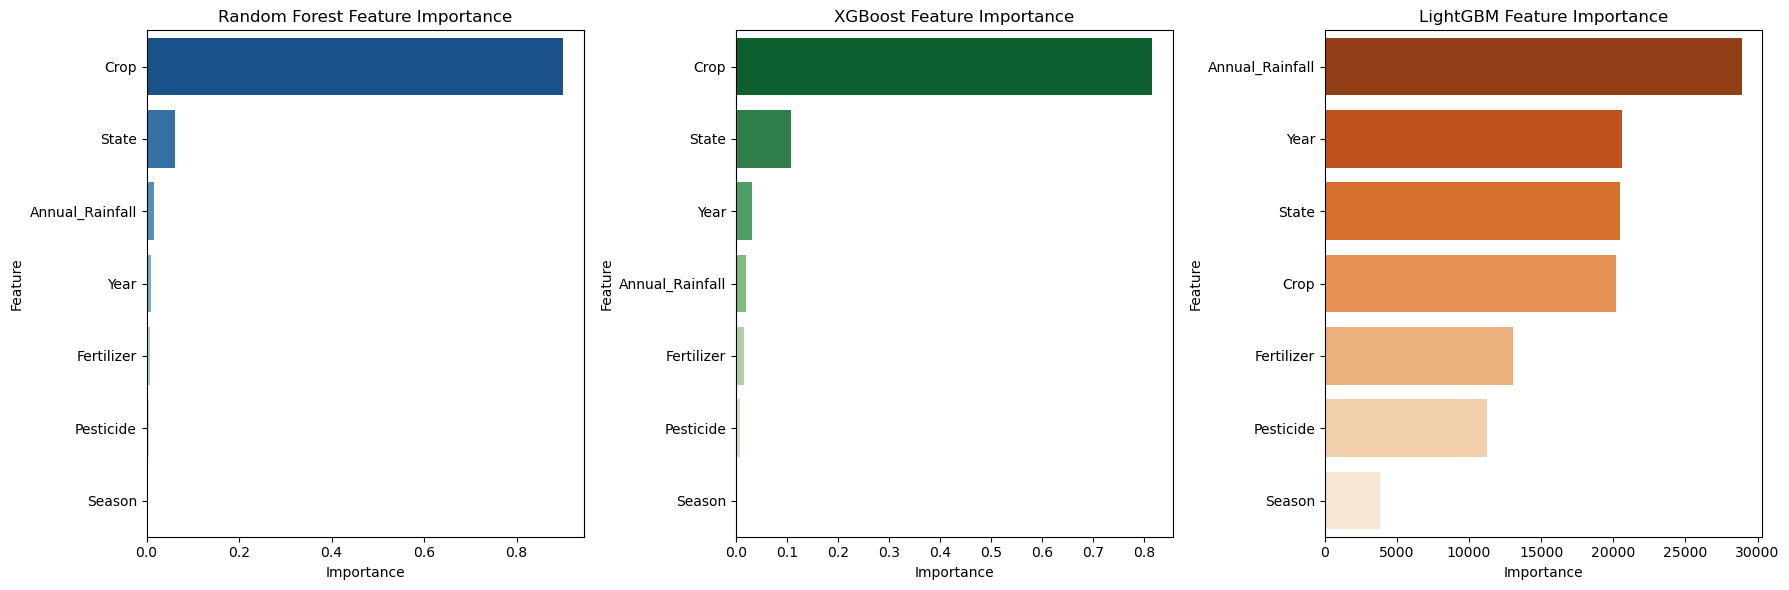

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Random Forest Feature Importance ---
rf_importances = rf.feature_importances_
rf_feat_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_importances})
rf_feat_imp = rf_feat_imp.sort_values('Importance', ascending=False).head(10)

# --- XGBoost Feature Importance ---
xgb_importances = xgb.feature_importances_
xgb_feat_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_importances})
xgb_feat_imp = xgb_feat_imp.sort_values('Importance', ascending=False).head(10)

# --- LightGBM Feature Importance ---
lgb_importances = best_lgb.feature_importances_
lgb_feat_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgb_importances})
lgb_feat_imp = lgb_feat_imp.sort_values('Importance', ascending=False).head(10)

# --- Combined Plot ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(data=rf_feat_imp, x='Importance', y='Feature', ax=axes[0], palette='Blues_r')
axes[0].set_title("Random Forest Feature Importance")

sns.barplot(data=xgb_feat_imp, x='Importance', y='Feature', ax=axes[1], palette='Greens_r')
axes[1].set_title("XGBoost Feature Importance")

sns.barplot(data=lgb_feat_imp, x='Importance', y='Feature', ax=axes[2], palette='Oranges_r')
axes[2].set_title("LightGBM Feature Importance")

plt.tight_layout()
plt.show()


In [82]:
pip install shap

   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ------------------- -------------------- 262.1/548.0 kB ? eta -:--:--
   -------------------------------------- 548.0/548.0 kB 965.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


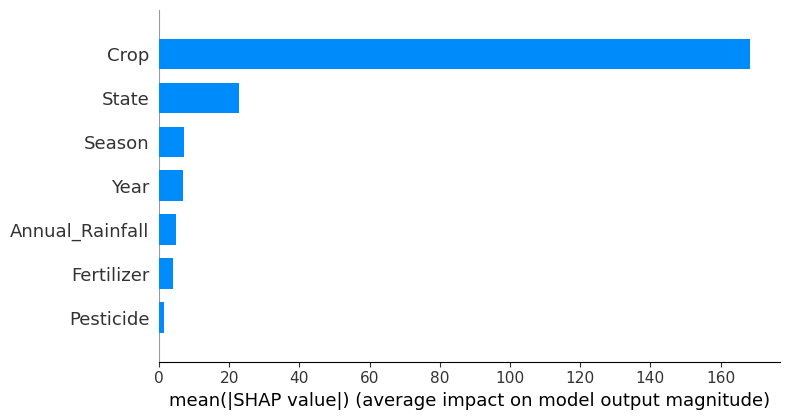

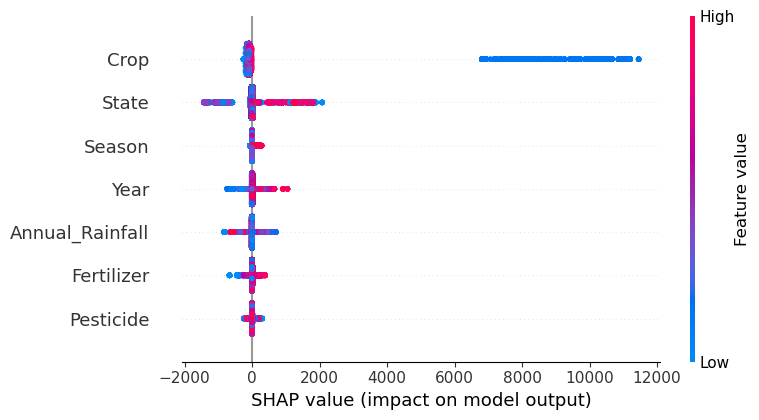

In [43]:
import shap

# Use your trained LightGBM model (replace with best model)
model = best_lgb  # or xgb_model

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Plot summary
shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)
